# Insight Data Science Seattle Interview Demo

## Outline:

1. Pose a question: Is a new user going to make a booking on Airbnb?
2. Prepare a relevant data set
3. Exploratory data analysis: Visualization/ Preprocessing/ Feature extraction
4. Select metrics to measure model performance
5. Build a predictive model

### 1. Define goal

The goal is to use information about a user of Airbnb to make predictions on if he/she will make a booking. 

### 2. Prepare data set

Data for this project is downloaded from the Kaggle competition website:
https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data

Dataset contains information of users that created their account between July 1, 2012 and July 1, 2014 (2 years). The dataset was uploaded on Dec 5, 2015 and we assume that all the users had enough time to make a booking if they ever wanted to.

In [1]:
import warnings
warnings.filterwarnings('ignore')    # suppress warnings for clean demo

pd.set_option('display.max_rows', None)    #don't hide any rows or columns when display
pd.set_option('display.max_columns', None)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
import datetime

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from scipy import sparse
from sklearn.model_selection import train_test_split, GridSearchCV

#### Read in dataset

In [3]:
users_data = pd.read_csv("airbnb_short.csv")

In [4]:
num_rows, num_cols = users_data.shape
print("There are {:,} rows and {:,} columns in the data.".format(num_rows, num_cols))

There are 183,537 rows and 7 columns in the data.


In [5]:
users_data.head(3)

,id,date_account_created,gender,age,affiliate_channel,signup_app,Booking
0,oamfblpxdy,2014-01-15,OTHER,45.0,direct,Moweb,True
1,5p0nmf3r6i,2014-05-23,FEMALE,39.0,direct,Web,False
2,dlg3a9x97v,2014-04-03,MALE,47.0,sem-brand,Web,False


- `age`
- `gender`
- `date_account_created`. These are the date on which users created their accounts. 
- `affiliate_channel`. This is the kind of paid marketing that a user is brought in by. For example, SEM means search engine marketing.
- `signup_app`. These are applications through which the users signed up.

In [6]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183537 entries, 0 to 183536
Data columns (total 7 columns):
id                      183537 non-null object
date_account_created    183537 non-null object
gender                  183537 non-null object
age                     105383 non-null float64
affiliate_channel       183537 non-null object
signup_app              183537 non-null object
Booking                 183537 non-null bool
dtypes: bool(1), float64(1), object(5)
memory usage: 8.6+ MB


##### Quick summary of  `Booking`

In [7]:
# percentage of booking for the entire dataset
users_data['Booking'].value_counts()/float(users_data.shape[0]) * 100.

False    60.060914
True     39.939086
Name: Booking, dtype: float64

*Finding: About 40% of the users in the dataset made a booking.*

### 3. Exploratory Data Analysis
- Target
- `age`
- Categorical features
- Datetime features

#### Label encode target `Booking`

In [8]:
label_encoder = LabelEncoder()
users_data.loc[:, 'Booking'] = label_encoder.fit_transform(users_data['Booking'])
country_code_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [9]:
# mapping between booking and its code
country_code_map

{False: 0, True: 1}

####  Preprocess the `age` column

##### Missing and invalid `age`

In [10]:
print("Percentage of missing age value in the data: {:.2f}%".format(sum(users_data.age.isnull())/num_rows * 100.))

Percentage of missing age value in the data: 42.58%


In [11]:
# percentage of booking among users with missing age
users_data[users_data.age.isnull()].Booking.value_counts(normalize = True) * 100.

0    79.496891
1    20.503109
Name: Booking, dtype: float64

In [12]:
# percentage of booking among users with age
users_data[~users_data.age.isnull()].Booking.value_counts(normalize = True) * 100.

1    54.353169
0    45.646831
Name: Booking, dtype: float64

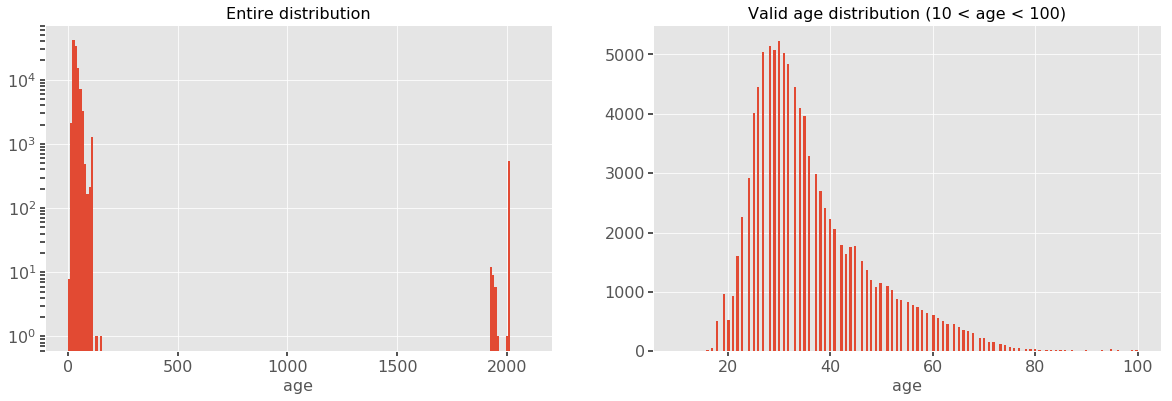

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6), sharex = False, sharey = False)

ax[0].hist(users_data.age, range = (0, 2100), log = True, bins = 200, normed = False);
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_title('Entire distribution', fontsize = 16);
ax[0].set_xlabel('age', fontsize = 16);

ax[1].hist(users_data.age, range = (10, 100), log = False, bins = 200, normed = False);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_title('Valid age distribution (10 < age < 100)', fontsize = 16);
ax[1].set_xlabel('age', fontsize = 16);

##### Select valid `age` entries to be 10 < age < 100

In [14]:
valid_age_index = users_data.age.apply(lambda x: 10 < x < 100)

##### Impute missing/invalid `age` with 0

In [15]:
users_data.loc[~valid_age_index, 'age'] = 0

##### Log transform `age`

In [16]:
# ln (1 + x)
users_data.loc[:,'age'] = np.log1p(users_data.age)

##### Standardize `age`

In [17]:
standardizer = StandardScaler()
users_data.loc[:, 'age'] = standardizer.fit_transform(users_data.age.values.reshape(-1, 1))

##### Histogram of `age` after preprocessing

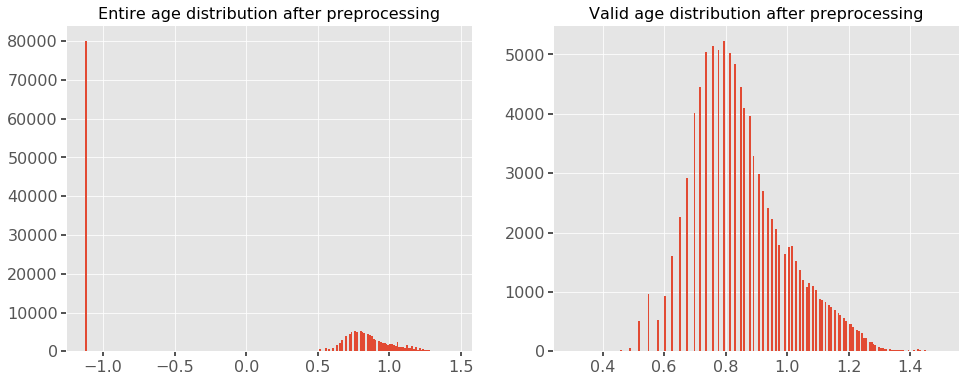

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6), sharex = False, sharey = False)

ax[0].hist(users_data.age, log = False, bins = 200, normed = False);
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_title('Entire age distribution after preprocessing', fontsize = 16);

ax[1].hist(users_data.age, range = (0.3, 1.5), log = False, bins = 200, normed = False);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_title('Valid age distribution after preprocessing', fontsize = 16);

#### Categorical features

In [19]:
cat_features = users_data.columns.tolist()
cat_features = [i for i in cat_features if i not in ('Booking', 'id', 'age', 'date_account_created', 'timestamp_first_active')]
print('Total number of categorical features: {}'.format(len(cat_features)))
print('They are:', cat_features)

Total number of categorical features: 3
They are: ['gender', 'affiliate_channel', 'signup_app']


In [23]:
users_data.gender.value_counts(normalize = True)

-unknown-    0.463863
FEMALE       0.287174
MALE         0.247748
OTHER        0.001215
Name: gender, dtype: float64

In [24]:
users_data.affiliate_channel.value_counts(normalize = True)

direct           0.656260
sem-brand        0.132437
sem-non-brand    0.079183
api              0.042084
seo              0.039861
other            0.026567
content          0.018574
remarketing      0.005034
Name: affiliate_channel, dtype: float64

In [25]:
users_data.signup_app.value_counts(normalize = True)

Web        0.834153
iOS        0.102116
Moweb      0.034015
Android    0.029716
Name: signup_app, dtype: float64

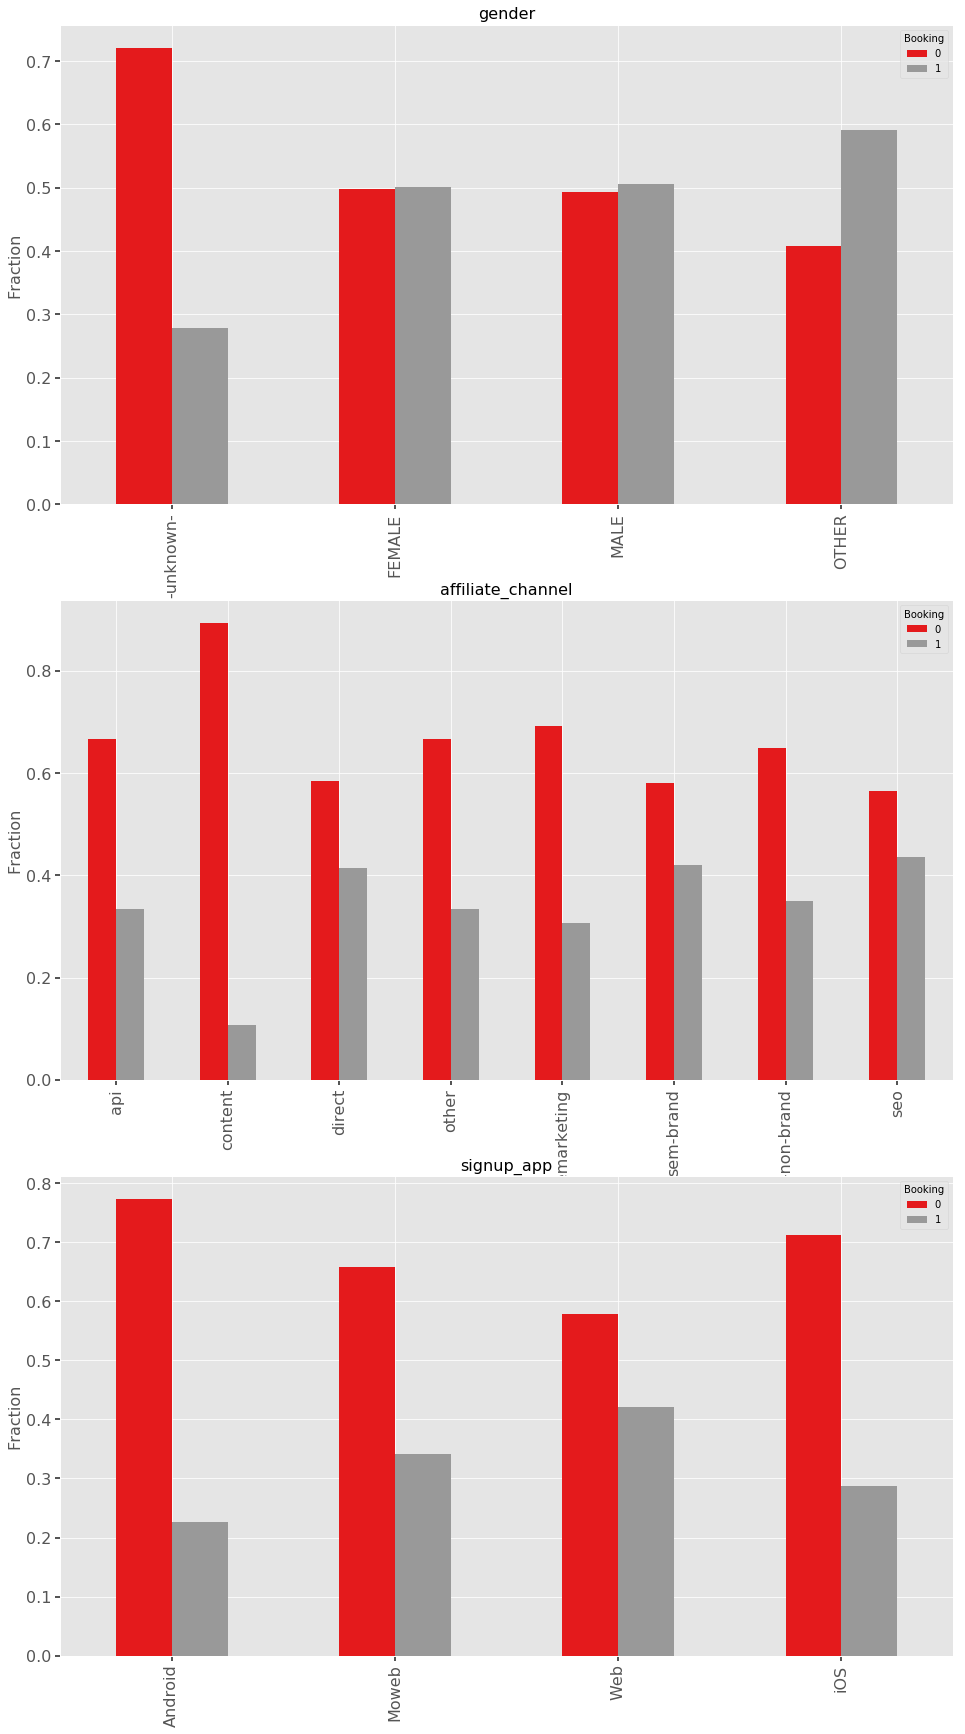

In [26]:
bar_order = users_data['Booking'].value_counts().index.tolist()
fig = plt.figure(figsize = (16, 30));

i = 1
for feat in cat_features:
    cross_tab = pd.crosstab(users_data.Booking, [users_data.loc[:,feat]])
    ax = fig.add_subplot(len(cat_features), 1, i);
    
    ax.tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
    tmp = pd.crosstab([users_data.loc[:,feat]], users_data.Booking).apply(lambda x: x/x.sum(), axis=1)
    tmp.plot(kind='bar', stacked=False, ax = ax, legend = True, colormap = 'Set1');
    ax.set_xlabel('');
    ax.set_ylabel('Fraction', fontsize = 16);
    ax.set_title(feat, fontsize = 16);
    i += 1

##### Label encode categorical features

In [27]:
feat_code_map = dict()
for feat in cat_features:
    users_data.loc[:, feat] = label_encoder.fit_transform(users_data[feat])
    feat_code_map[feat]=dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

##### One-hot encode categorical features

In [28]:
one_hot_encoder = OneHotEncoder(sparse = True)
users_cat_data = one_hot_encoder.fit_transform(users_data[cat_features])
print (users_cat_data.shape)

(183537, 16)


#### Datetime features 
##### Convert to datetime data type

In [29]:
users_data.loc[:,'date_account_created'] = pd.to_datetime(users_data.date_account_created)

#### Extract features from datetime columns

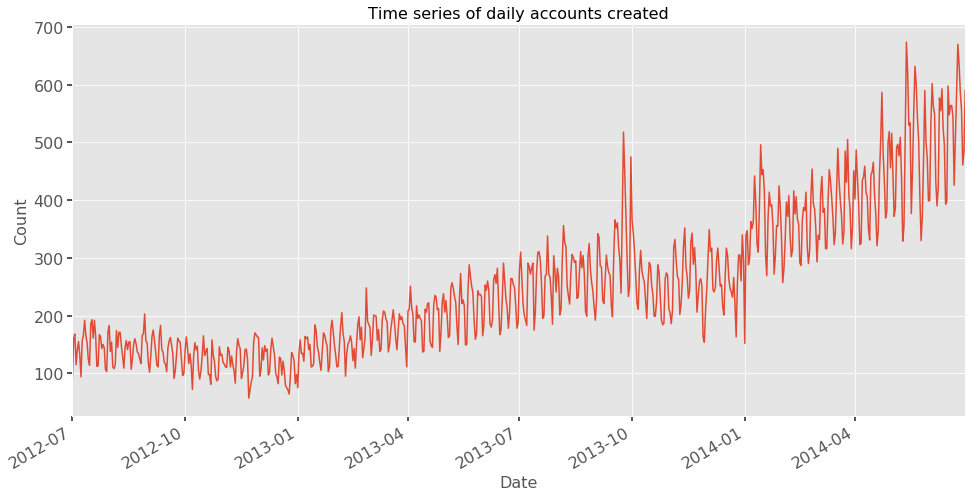

In [30]:
fig, ax = plt.subplots(figsize = (16, 8));
users_data.date_account_created.value_counts().plot();
ax.tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax.set_title('Time series of daily accounts created', fontsize = 16);
ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Count', fontsize = 16);

##### Year, month, day in month, day in week, holiday features

In [31]:
users_data['year_account_created'] = users_data.date_account_created.apply(lambda x: x.year)
users_data['month_account_created'] = users_data.date_account_created.apply(lambda x: x.month)
users_data['dayinmonth_account_created'] = users_data.date_account_created.apply(lambda x: x.day)
# Monday is 1 and Sunday is 7
users_data['dayinweek_account_created'] = users_data.date_account_created.apply(lambda x: x.isoweekday())

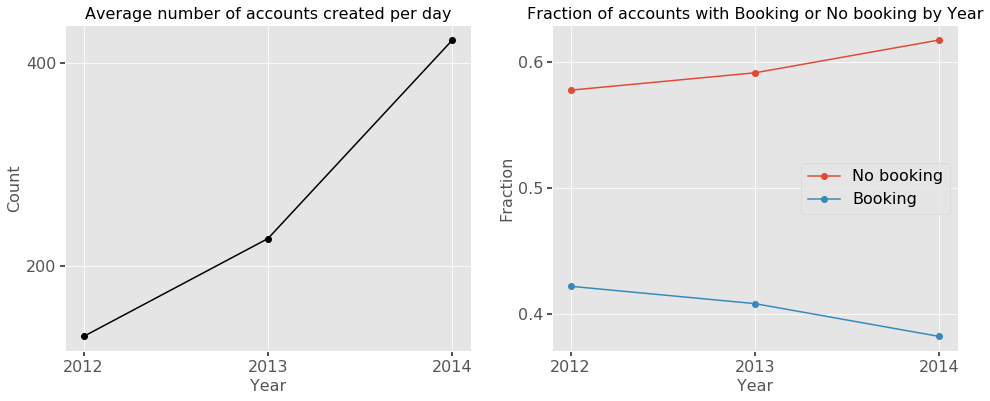

In [32]:
bookings_byyear = users_data.loc[:, ['Booking', 'year_account_created']].groupby(['year_account_created','Booking']).size().unstack('Booking')
bookings_byyear['total'] = bookings_byyear.iloc[:, 0] + bookings_byyear.iloc[:, 1]
bookings_byyear['no_booking_fraction'] = bookings_byyear.iloc[:, 0] / bookings_byyear['total']
bookings_byyear['booking_fraction'] = bookings_byyear.iloc[:, 1] / bookings_byyear['total']
bookings_byyear['number_of_days'] = users_data.loc[:, ['date_account_created', 'year_account_created']]\
                                       .groupby(['year_account_created']).nunique().loc[:,'date_account_created']
bookings_byyear['avg_account_per_day'] = bookings_byyear.total / bookings_byyear.number_of_days


fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

ax[0].plot(bookings_byyear.avg_account_per_day, 'o-', color = 'black');
ax[0].set_title('Average number of accounts created per day', fontsize = 16)
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_xlabel('Year', fontsize = 16);
ax[0].set_ylabel('Count', fontsize = 16);
ax[0].locator_params(nbins = 3);

ax[1].plot(bookings_byyear.no_booking_fraction, 'o-', label = 'No booking');
ax[1].set_title('Fraction of accounts with Booking or No booking by Year', fontsize = 16)
ax[1].plot(bookings_byyear.booking_fraction, 'o-', label = 'Booking');
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_xlabel('Year', fontsize = 16);
ax[1].set_ylabel('Fraction', fontsize = 16);
ax[1].locator_params(nbins = 3);

*Findings:*
- Average number of accounts per day increases from 2012 to 2014.
- However, the fraction of users who made a booking decreases slightly over the same period of time.

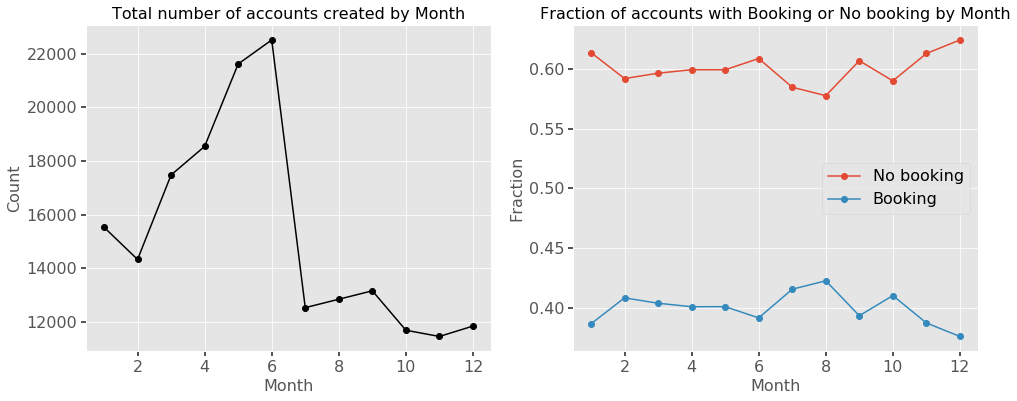

In [33]:
bookings_bymonth = users_data.loc[:, ['Booking', 'month_account_created']].groupby(['month_account_created','Booking']).size().unstack('Booking')
bookings_bymonth['total'] = bookings_bymonth.iloc[:, 0] + bookings_bymonth.iloc[:, 1]
bookings_bymonth['no_booking_fraction'] = bookings_bymonth.iloc[:, 0] / bookings_bymonth['total']
bookings_bymonth['booking_fraction'] = bookings_bymonth.iloc[:, 1] / bookings_bymonth['total']

fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

ax[0].plot(bookings_bymonth.total, 'o-', color = 'black');
ax[0].set_title('Total number of accounts created by Month', fontsize = 16)
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_xlabel('Month', fontsize = 16);
ax[0].set_ylabel('Count', fontsize = 16);

ax[1].plot(bookings_bymonth.no_booking_fraction, 'o-', label = 'No booking');
ax[1].set_title('Fraction of accounts with Booking or No booking by Month', fontsize = 16)
ax[1].plot(bookings_bymonth.booking_fraction, 'o-', label = 'Booking');
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_xlabel('Month', fontsize = 16);
ax[1].set_ylabel('Fraction', fontsize = 16);

*Findings:*
- In terms of total number of accounts created, June is highest, which is almost twice as the lowest month (Nov).
- In terms of the fraction of users who made a booking, the monthly variation is not that large. July and August are slightly higher.

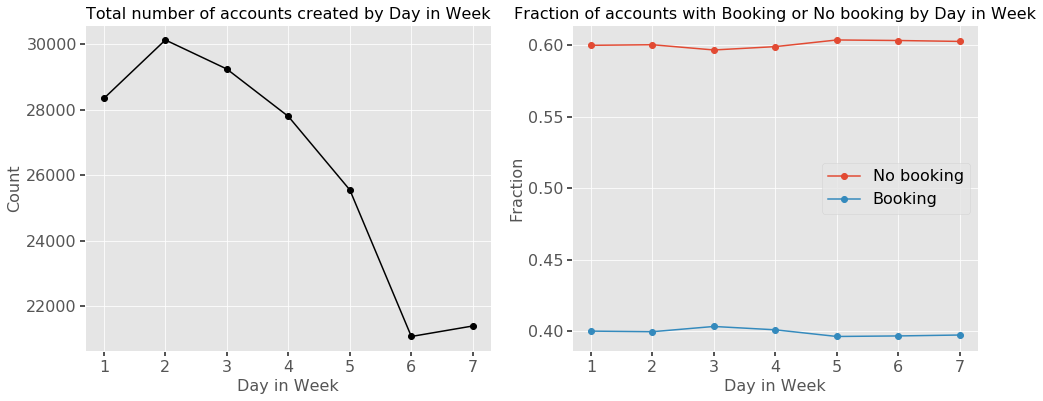

In [34]:
bookings_bydayinweek = users_data.loc[:, ['Booking', 'dayinweek_account_created']].groupby(['dayinweek_account_created','Booking']).size().unstack('Booking')
bookings_bydayinweek['total'] = bookings_bydayinweek.iloc[:, 0] + bookings_bydayinweek.iloc[:, 1]
bookings_bydayinweek['no_booking_fraction'] = bookings_bydayinweek.iloc[:, 0] / bookings_bydayinweek['total']
bookings_bydayinweek['booking_fraction'] = bookings_bydayinweek.iloc[:, 1] / bookings_bydayinweek['total']

fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

ax[0].plot(bookings_bydayinweek.total, 'o-', color = 'black');
ax[0].set_title('Total number of accounts created by Day in Week', fontsize = 16)
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_xlabel('Day in Week', fontsize = 16);
ax[0].set_ylabel('Count', fontsize = 16);

ax[1].plot(bookings_bydayinweek.no_booking_fraction, 'o-', label = 'No booking');
ax[1].set_title('Fraction of accounts with Booking or No booking by Day in Week', fontsize = 16)
ax[1].plot(bookings_bydayinweek.booking_fraction, 'o-', label = 'Booking');
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_xlabel('Day in Week', fontsize = 16);
ax[1].set_ylabel('Fraction', fontsize = 16);

*Findings:*
- Tuesday is the day of week most users sign up for account on Airbnb. Saturday has least number of users create accounts.
- The fraction of users who made a booking is almost constant in terms of the day in week.

In [35]:
users_data.drop('dayinweek_account_created', axis = 1, inplace = True)

In [36]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start = users_data.date_account_created.min(), 
                        end = users_data.date_account_created.max())

users_data['Holiday'] = users_data.date_account_created.isin(holidays)

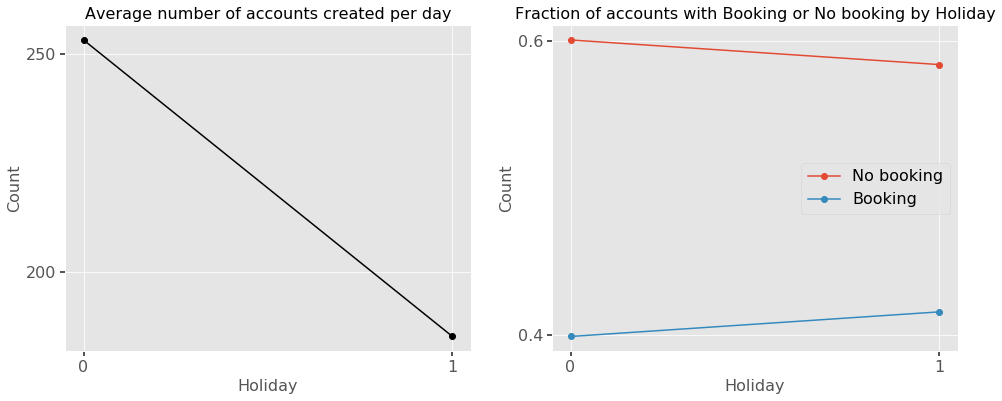

In [37]:
bookings_byholiday = users_data.loc[:, ['Booking', 'Holiday']].groupby(['Holiday','Booking']).size().unstack('Booking')
bookings_byholiday['total'] = bookings_byholiday.iloc[:, 0] + bookings_byholiday.iloc[:, 1]
bookings_byholiday['no_booking_fraction'] = bookings_byholiday.iloc[:, 0] / bookings_byholiday['total']
bookings_byholiday['booking_fraction'] = bookings_byholiday.iloc[:, 1] / bookings_byholiday['total']
bookings_byholiday['number_of_days'] = users_data.loc[:, ['date_account_created', 'Holiday']]\
                                       .groupby(['Holiday']).nunique().loc[:,'date_account_created']
bookings_byholiday['avg_account_per_day'] = bookings_byholiday.total / bookings_byholiday.number_of_days
fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

ax[0].plot(bookings_byholiday.avg_account_per_day, 'o-', color = 'k');
ax[0].set_title('Average number of accounts created per day', fontsize = 16)
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_xlabel('Holiday', fontsize = 16);
ax[0].set_ylabel('Count', fontsize = 16);
ax[0].locator_params(nbins = 2);

ax[1].plot(bookings_byholiday.no_booking_fraction, 'o-',label = 'No booking');
ax[1].set_title('Fraction of accounts with Booking or No booking by Holiday', fontsize = 16)
ax[1].plot(bookings_byholiday.booking_fraction, 'o-', label = 'Booking');
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_xlabel('Holiday', fontsize = 16);
ax[1].set_ylabel('Count', fontsize = 16);
ax[1].locator_params(nbins = 2);

*Finding:*
- Less people sign up accounts on US holidays than on other days.
- The fraction of users who made a booking on holiday is slightly higher than on other days.

#### Label & One-hot encode datetime features

In [38]:
datetime_features = ['year_account_created', 'month_account_created', 'dayinmonth_account_created', 'Holiday']
# Label encode
for feat in datetime_features:
    users_data.loc[:, feat] = label_encoder.fit_transform(users_data[feat])
    feat_code_map[feat] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# One-hot encode
users_datetime_data = one_hot_encoder.fit_transform(users_data[datetime_features])
print (users_datetime_data.shape)

(183537, 48)


### 4. Select metrics to measure model performance

In this problem, `True` outcomes correspond to users who made a booking; `False` outcomes correspond to users who don't make a bookings.

`Accuracy` is one metric that could measure the model performance. 

However, `Precision` and `Recall` (or `Sensitivity`) could also be used to measure the model and focuses more on the users who made a booking.

- `Precision` = True Positives / (True Positives + False Positives) = fraction of TP in all predicted True
- `Recall` = True Positives / (True Positives + False Negatives) = fraction of TP in all True True

In this case, let's say we want to build a model that's good at both `Precision` and `Recall` and choose `F1 score`.

$$ \textrm{F}_{1} = \frac{\textrm{precision} \cdot \textrm{recall}}{\textrm{precision} + \textrm{recall}} $$


#### Naive predictor performance

A naive predictor is to predict that all the users make a booking.

In [53]:
beta = 1.
accuracy_naive = sum(users_data['Booking'] == 1)/float(users_data.shape[0])
precision_naive = sum(users_data['Booking'] == 1)/float(users_data.shape[0])
recall_naive = 1.
f1_naive = (1. + beta**2) * (precision_naive * recall_naive) / (recall_naive + beta**2 * precision_naive)
print("Accuracy = {:.4f}".format((accuracy_naive)))
print("Precision = {:.4f}".format(precision_naive))
print("Recall = {:.4f}".format(recall_naive))
print("F1 score(beta = 1) = {:.4f}".format(f1_naive))

Accuracy = 0.3994
Precision = 0.3994
Recall = 1.0000
F1 score(beta = 1) = 0.5708


### 5. Build a predictive model

#### Split data into 80% for training and 20% for testing

In [44]:
full_data_sparse = sparse.hstack((users_cat_data, 
                                  users_datetime_data, 
                                  np.array(users_data['age'])[:, None]), 
                                 format='csr')
print ("Check number of columns: ", full_data_sparse.shape[1], "==", 
       users_cat_data.shape[1] + users_datetime_data.shape[1] + 1)

Check number of columns:  65 == 65


In [45]:
target = users_data['Booking']

In [46]:
# Split the features and target data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_data_sparse, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 146829 samples.
Testing set has 36708 samples.


#### Build a logistic regression model

Other models: SVM, tree-based (boosting, Random Forest), etc.

In [47]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# class_weight = “balanced”: adjust weights inversely proportional to class frequencies in the input data 
logistic_reg =  LogisticRegression(class_weight = 'balanced', verbose = 10, random_state = 0)

# C: smaller values specify stronger regularization
parameter_candidates = [{'C':[1e-3, 1e-2, 1e-1], 
                         'penalty':['l1','l2']}]

models = GridSearchCV(estimator = logistic_reg, 
                      param_grid = parameter_candidates,
                      scoring = ['accuracy', 'f1'],
                      cv = 5,
                      n_jobs = -1,
                      verbose = 10,
                      refit = 'f1')

models.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] penalty=l1, C=0.001 .............................................
[CV] penalty=l1, C=0.001 .............................................
[CV] penalty=l1, C=0.001 .............................................
[CV] penalty=l1, C=0.001 .............................................
[LibLinear][CV]  penalty=l1, C=0.001, f1=0.6363990785043416, accuracy=0.650650412041136, total=   0.5s
[CV] penalty=l1, C=0.001 .............................................
[LibLinear][CV]  penalty=l1, C=0.001, f1=0.6386156132776559, accuracy=0.6522509024041409, total=   0.5s
[CV] penalty=l2, C=0.001 .............................................
[LibLinear][CV]  penalty=l1, C=0.001, f1=0.6360606920022689, accuracy=0.6504120411360076, total=   0.5s
[CV] penalty=l2, C=0.001 .............................................
[LibLinear][CV]  penalty=l1, C=0.001, f1=0.6314563928873835, accuracy=0.6442825035755636, total=   0.9s
[CV] penalty=l2, C=0.001 ...

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[LibLinear][CV]  penalty=l2, C=0.001, f1=0.6323349852761617, accuracy=0.6513655247565211, total=   0.7s
[CV] penalty=l2, C=0.001 .............................................
[LibLinear][CV]  penalty=l2, C=0.001, f1=0.635968722849696, accuracy=0.6575631682898591, total=   0.8s
[CV] penalty=l1, C=0.01 ..............................................
[LibLinear][CV]  penalty=l2, C=0.001, f1=0.6386682074245269, accuracy=0.6592658176122046, total=   0.8s
[CV] penalty=l1, C=0.01 ..............................................
[LibLinear][CV]  penalty=l2, C=0.001, f1=0.6339904876012055, accuracy=0.6567118436286863, total=   0.8s
[CV] penalty=l1, C=0.01 ..............................................
[LibLinear][CV]  penalty=l2, C=0.001, f1=0.6334429547179358, accuracy=0.6545887961859357, total=   0.9s
[CV] penalty=l1, C=0.01 ..............................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s


[LibLinear][CV]  penalty=l1, C=0.01, f1=0.6383959606307855, accuracy=0.6634543349451747, total=   5.0s
[CV] penalty=l1, C=0.01 ..............................................
[LibLinear][CV]  penalty=l1, C=0.01, f1=0.6328579743888243, accuracy=0.6563372607777702, total=   6.6s
[CV] penalty=l2, C=0.01 ..............................................
[LibLinear][CV]  penalty=l1, C=0.01, f1=0.6358525921299188, accuracy=0.6625008513246612, total=   7.6s
[CV] penalty=l2, C=0.01 ..............................................
[LibLinear][CV]  penalty=l2, C=0.01, f1=0.6305896174462149, accuracy=0.6573588503711776, total=   1.9s
[CV] penalty=l2, C=0.01 ..............................................
[LibLinear][CV]  penalty=l1, C=0.01, f1=0.6359338927773095, accuracy=0.6616835796499353, total=   9.5s
[CV] penalty=l2, C=0.01 ..............................................
[LibLinear][CV]  penalty=l2, C=0.01, f1=0.6354097391561369, accuracy=0.6639651297418784, total=   1.2s
[CV] penalty=l2, C=0.01 ...

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.5s


[LibLinear][CV]  penalty=l2, C=0.01, f1=0.6318601803406434, accuracy=0.6621603214601921, total=   1.4s
[CV] penalty=l1, C=0.1 ...............................................
[LibLinear][CV]  penalty=l2, C=0.01, f1=0.6329244864784985, accuracy=0.661638004427039, total=   1.4s
[CV] penalty=l1, C=0.1 ...............................................
[LibLinear][CV]  penalty=l1, C=0.01, f1=0.6345745848269807, accuracy=0.6597990805380555, total=   6.5s
[CV] penalty=l1, C=0.1 ...............................................
[LibLinear][CV]  penalty=l1, C=0.1, f1=0.6353480801953096, accuracy=0.6643056596063475, total=  10.6s
[CV] penalty=l1, C=0.1 ...............................................
[LibLinear][CV]  penalty=l1, C=0.1, f1=0.6326001629267569, accuracy=0.6621262684737451, total=  18.1s
[CV] penalty=l2, C=0.1 ...............................................
[LibLinear][CV]  penalty=l1, C=0.1, f1=0.6312267657992565, accuracy=0.662194374446639, total=  17.4s
[CV] penalty=l2, C=0.1 .........

[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   35.5s remaining:    3.9s


[LibLinear][CV]  penalty=l2, C=0.1, f1=0.6306152071160073, accuracy=0.6620241095144044, total=   1.4s
[LibLinear][CV]  penalty=l2, C=0.1, f1=0.631957044991668, accuracy=0.6615358419887621, total=   1.2s
[LibLinear][CV]  penalty=l1, C=0.1, f1=0.6323730631263637, accuracy=0.6614677336965775, total=  12.7s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   37.8s finished


[LibLinear]CPU times: user 2.94 s, sys: 320 ms, total: 3.27 s
Wall time: 39.4 s


In [48]:
# best f1 score
models.best_score_

0.63552300741008794

In [49]:
# best combination of parameters
models.best_params_

{'C': 0.01, 'penalty': 'l1'}

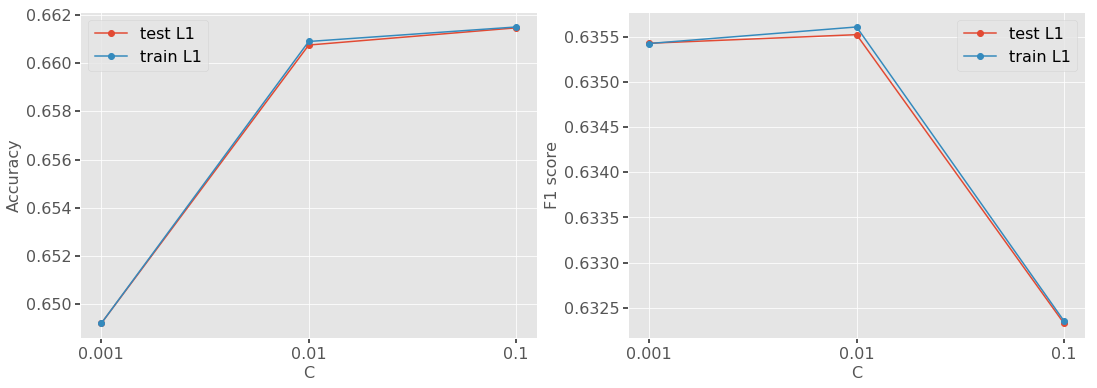

In [54]:
fig, ax = plt.subplots(ncols = 2, figsize = (18, 6))

l1_ind = [0, 2, 4]; l2_ind = [1, 3, 5]

ax[0].plot(l1_ind, models.cv_results_['mean_test_accuracy'][l1_ind], 'o-', label = 'test L1');
#ax[0].plot(l1_ind, models.cv_results_['mean_test_accuracy'][l2_ind], 'o-', label = 'test L2');
ax[0].plot(l1_ind, models.cv_results_['mean_train_accuracy'][l1_ind], 'o-', label = 'train L1');
#ax[0].plot(l1_ind, models.cv_results_['mean_train_accuracy'][l2_ind], 'o-', label = 'train L2');
ax[0].set_xticklabels([0.001, 0.01, 0.1]);
ax[0].set_xticks(l1_ind);
ax[0].set_xlabel('C', fontsize = 16);
ax[0].set_ylabel('Accuracy', fontsize = 16);
ax[0].legend(fontsize = 16);
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
#ax[0].axhline(y = accuracy_naive, color = 'k');

ax[1].plot(l1_ind, models.cv_results_['mean_test_f1'][l1_ind], 'o-', label = 'test L1');
#ax[1].plot(l1_ind, models.cv_results_['mean_test_f1'][l2_ind], 'o-', label = 'test L2');
ax[1].plot(l1_ind, models.cv_results_['mean_train_f1'][l1_ind], 'o-', label = 'train L1');
#ax[1].plot(l1_ind, models.cv_results_['mean_train_f1'][l2_ind], 'o-', label = 'train L2');
ax[1].set_xticklabels([0.001, 0.01, 0.1]);
ax[1].set_xticks(l1_ind);
ax[1].set_xlabel('C', fontsize = 16);
ax[1].set_ylabel('F1 score', fontsize = 16);
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
#ax[1].axhline(y = f1_naive, color = 'k');

Compared with the naive predictor, which has `Accuracy ~ 0.40` and `F1 ~ 0.57`, the best logistic regression model we found above has slightly better `Accuracy ~ 0.66` and `F1 ~ 0.64`.

#### Evaluate the best model on test data

In [55]:
# F1 score on test data
models.score(X_test, y_test)

0.63383372838205598

### Conclusion

The logistic regression model we built above is better than a naive predictor which always predict booking for all users in terms of both `Accuracy` and `F1 score`. In addition to that, our model could also provide more informaiton than a naive predictor in terms of which are the features are the most important.

However, our model's prediction ability is far from ideal and this indicates that the goal of this demo is not easily achieved with the input data. One way to improve is to gather more attributes for each users and use more sophisticated machine learning algorithm, like tree based models to allow nonlinearity in the model.